In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import sem, ttest_ind, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import math

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

(<Figure size 72x72 with 1 Axes>, <AxesSubplot:>)

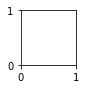

In [5]:
my_plot.instantiate_fig(1, 1)

# Load data

In [6]:
df_master = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_risk = pd.read_csv('./generated_tables/high_risk_swath_reviewed.csv')
df_dtr = pd.read_csv('./generated_tables/difficult_to_remove_swath_reviewed.csv')

df_master.replace(0.0, np.nan, inplace=True)
df_risk.replace(0.0, np.nan, inplace=True)
df_dtr.replace(0.0, np.nan, inplace=True)

df_master.set_index('name', inplace=True)
df_risk.set_index('name', inplace=True)
df_dtr.set_index('name', inplace=True)

sample_columns = ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_spf1', 'hccf_spf2', 'pavin_feed', 'pavin_large', 'pavin_small']
sample_nice_names = ['HCCF Feed', 'HCCF Large agg.', 'HCCF Small agg.', 'HCCF mAb', 'HCCF SPF 1', 'HCCF SPF 2', 'PAVIN Feed', 'PAVIN Large agg.', 'PAVIN Small agg.']
nice_name_map = {}
for i, sample_column in enumerate(sample_columns):
    nice_name_map[sample_column] = sample_nice_names[i]

# Process

In [7]:
def get_df_percentile(sample_column):
    df_temp = pd.DataFrame()
    df_temp[sample_column] = df_master[sample_column]
    df_temp.dropna(inplace=True)
    df_temp.sort_values(by=sample_column, inplace=True)
    df_temp['c_ppm'] = df_temp[sample_column]
    df_temp['log10_c_ppm'] = np.log10(df_temp[sample_column])
    percentile = np.arange(len(df_temp))/float(len(df_temp)) * 100.0
    df_temp['percentile'] = percentile
    df_temp['high_risk'] = False
    df_temp['dtr'] = False

    df_temp_risk = pd.DataFrame()
    df_temp_risk[sample_column] = df_risk[sample_column]
    df_temp_risk.dropna(inplace=True)
    df_temp.loc[df_temp_risk.index, 'high_risk'] = True

    df_temp_dtr = pd.DataFrame()
    df_temp_dtr[sample_column] = df_dtr[sample_column]
    df_temp_dtr.dropna(inplace=True)
    df_temp.loc[df_temp_dtr.index, 'dtr'] = True
    return df_temp

def get_df_plots(sample_column, category):
    df_temp = get_df_percentile(sample_column)
    df_plot_category = df_temp[df_temp[category]]
    df_plot_other = df_temp[~df_temp[category]]
    return df_plot_other, df_plot_category

In [8]:
sample_column = 'hccf_feed'
df_temp = get_df_percentile(sample_column)

# EDC plots

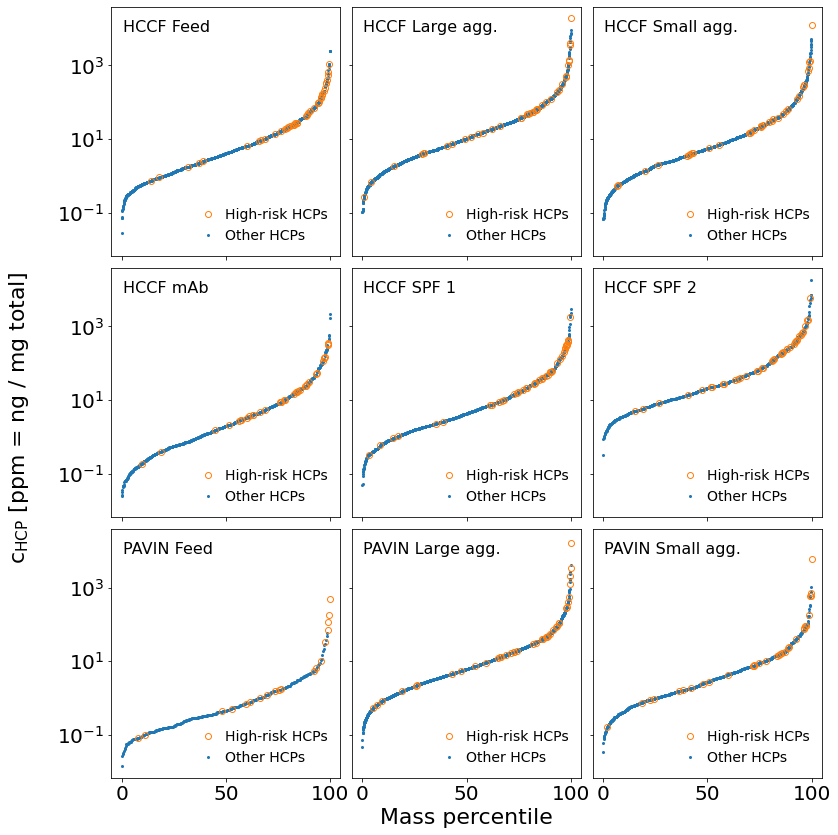

In [9]:
category = 'high_risk'
label = 'High-risk HCPs'

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
fig.supylabel(r'$\mathsf{c_{HCP}}$ [ppm = ng / mg total]', fontsize=22)
ax[2, 1].set_xlabel('Mass percentile', fontsize=22)
ax[0, 0].set_yscale('log')

for k, sample_column in enumerate(sample_columns):
    i, j = int(math.floor(k/3)), k%3
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    ax[i, j].plot(df_plot_other['percentile'], df_plot_other[sample_column], ls='', marker='o', label='Other HCPs', markersize=2)
    ax[i, j].plot(df_plot_category['percentile'], df_plot_category[sample_column], ls='', marker='o', label=label, fillstyle='none')
    ax[i, j].text(0.05, 0.9, nice_name_map[sample_column], transform=ax[i, j].transAxes, fontsize=16)

    handles, labels = ax[i, j].get_legend_handles_labels()
    order = [1, 0]
    ax[i, j].legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=14, handletextpad=0.2, loc='lower right')

my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(f'./images/15_ecdf_plots_{category}.png', dpi=300)

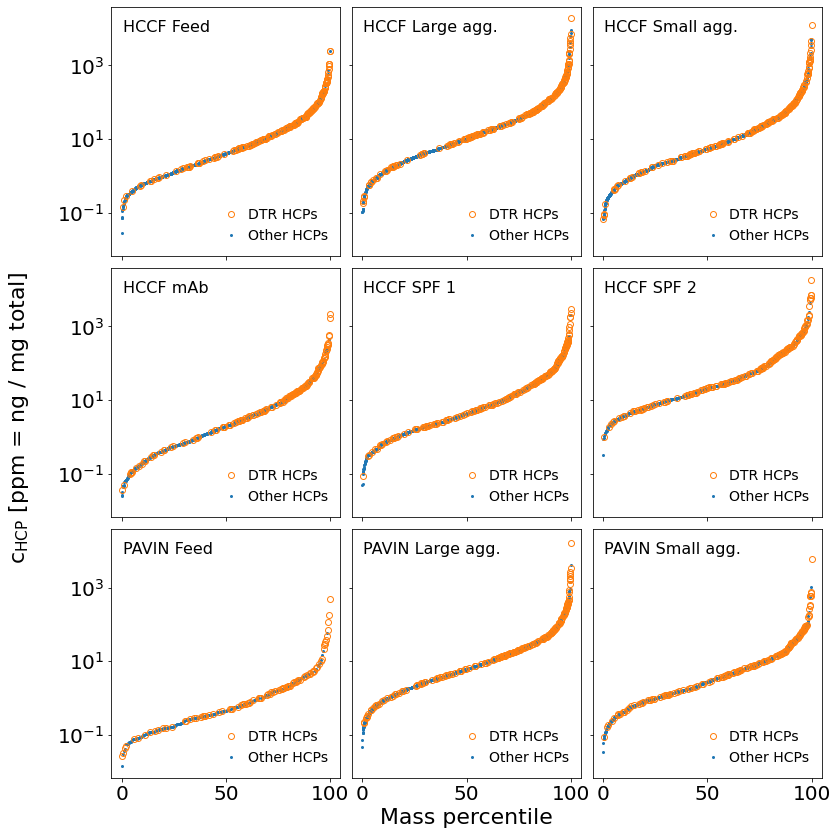

In [10]:
category = 'dtr'
label = 'DTR HCPs'

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
fig.supylabel(r'$\mathsf{c_{HCP}}$ [ppm = ng / mg total]', fontsize=22)
ax[2, 1].set_xlabel('Mass percentile', fontsize=22)
ax[0, 0].set_yscale('log')

for k, sample_column in enumerate(sample_columns):
    i, j = int(math.floor(k/3)), k%3
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    ax[i, j].plot(df_plot_other['percentile'], df_plot_other[sample_column], ls='', marker='o', label='Other HCPs', markersize=2)
    ax[i, j].plot(df_plot_category['percentile'], df_plot_category[sample_column], ls='', marker='o', label=label, fillstyle='none')
    ax[i, j].text(0.05, 0.9, nice_name_map[sample_column], transform=ax[i, j].transAxes, fontsize=16)

    handles, labels = ax[i, j].get_legend_handles_labels()
    order = [1, 0]
    ax[i, j].legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=14, handletextpad=0.2, loc='lower right')

my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(f'./images/15_ecdf_plots_{category}.png', dpi=300)

# Histograms

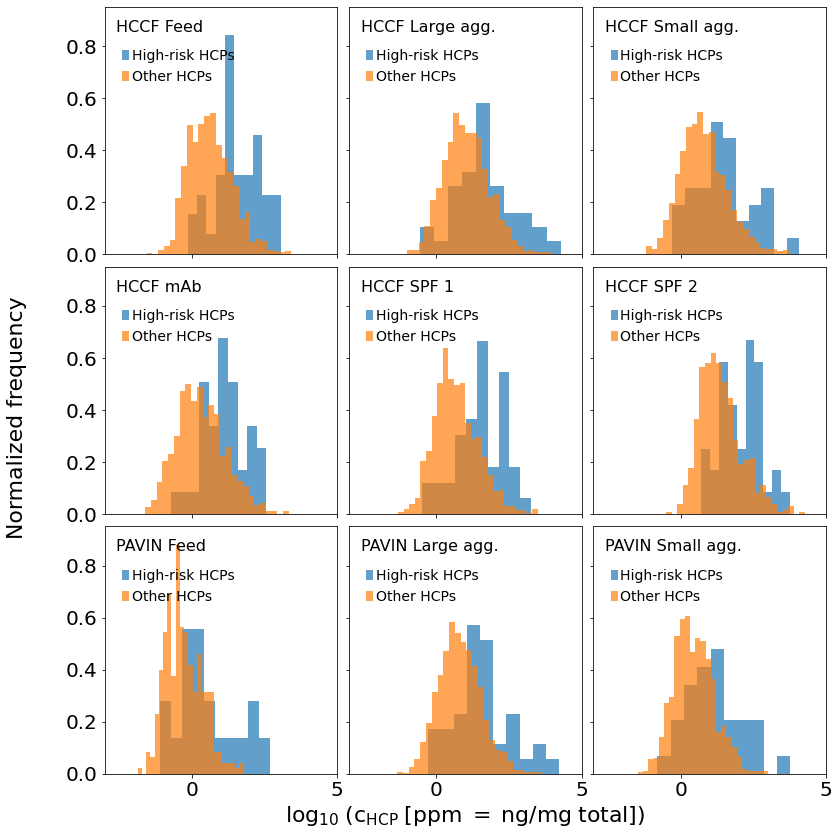

In [11]:
category = 'high_risk'
label = 'High-risk HCPs'

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
fig.supylabel('Normalized frequency', fontsize=22)
ax[2, 1].set_xlabel(r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng/mg \; total] \right)}$', fontsize=22)

for k, sample_column in enumerate(sample_columns):
    i, j = int(math.floor(k/3)), k%3
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    
    n_cat = ax[i, j].hist(df_plot_category.log10_c_ppm, density=True, bins=10, alpha=0.7, label=label)
    n_other = ax[i, j].hist(df_plot_other.log10_c_ppm, density=True, bins=25, alpha=0.7, label='Other HCPs')
    
    ax[i, j].text(0.05, 0.9, nice_name_map[sample_column], transform=ax[i, j].transAxes, fontsize=16)
    ax[i, j].legend(frameon=False, fontsize=14, handletextpad=0.2, loc='upper left', handlelength=0.5, bbox_transform=ax[i, j].transAxes, bbox_to_anchor=(0.02, 0.88))

ax[0, 0].set_ylim(0, 0.95)
ax[0, 0].set_xlim(-3, 5)
my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(f'./images/15_histograms_{category}.png', dpi=300)

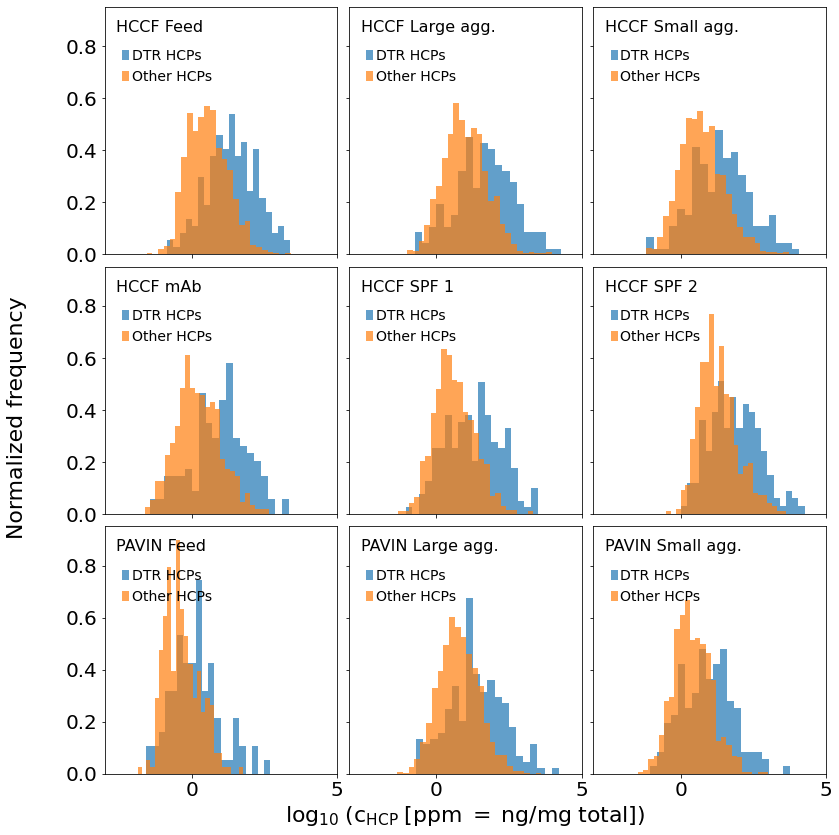

In [12]:
category = 'dtr'
label = 'DTR HCPs'

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
fig.supylabel('Normalized frequency', fontsize=22)
ax[2, 1].set_xlabel(r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng/mg \; total] \right)}$', fontsize=22)

for k, sample_column in enumerate(sample_columns):
    i, j = int(math.floor(k/3)), k%3
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    
    n_cat = ax[i, j].hist(df_plot_category.log10_c_ppm, density=True, bins=20, alpha=0.7, label=label)
    n_other = ax[i, j].hist(df_plot_other.log10_c_ppm, density=True, bins=25, alpha=0.7, label='Other HCPs')
    
    ax[i, j].text(0.05, 0.9, nice_name_map[sample_column], transform=ax[i, j].transAxes, fontsize=16)
    ax[i, j].legend(frameon=False, fontsize=14, handletextpad=0.2, loc='upper left', handlelength=0.5, bbox_transform=ax[i, j].transAxes, bbox_to_anchor=(0.02, 0.88))

ax[0, 0].set_ylim(0, 0.95)
ax[0, 0].set_xlim(-3, 5)
my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(f'./images/15_histograms_{category}.png', dpi=300)

# Violin plots

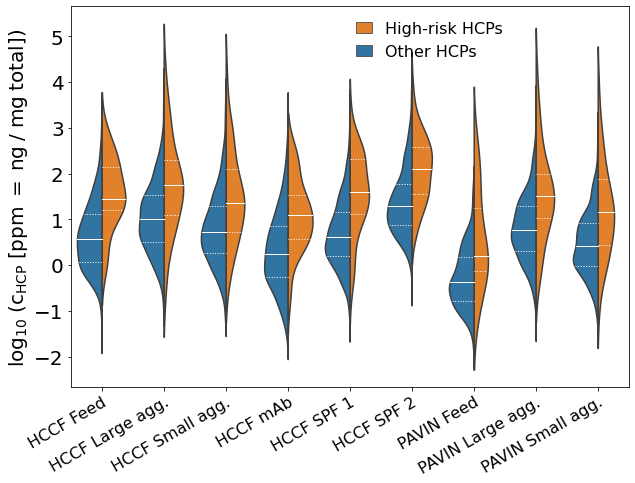

In [13]:
category = 'high_risk'
label = 'High-risk HCPs'

# Prepare a consolidated df_violin
for k, sample_column in enumerate(sample_columns):
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    df_plot_category[category] = label
    df_plot_other[category] = 'Other HCPs'
    df_plot_category['sample'] = nice_name_map[sample_column]
    df_plot_other['sample'] = nice_name_map[sample_column]
    if k == 0:
        df_violin = df_plot_other.copy()
    else:
        df_violin = pd.concat([df_violin, df_plot_other])
    df_violin = pd.concat([df_violin, df_plot_category])
    
df_violin.rename(columns={'c_ppm':r'$\mathsf{c_HCP}$ [ppm = ng / mg total]', 
                          'log10_c_ppm':r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$'}, inplace=True)

# Make plot
plt.gcf().set_size_inches(10, 7)
ax = sns.violinplot(data=df_violin, x='sample', y=r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$', 
                    hue=category, split=True, inner='quartile')

# Modify xtick labels
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor', fontsize=16)
hide = ax.set(xlabel=None)

# Modify legend
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=16, handlelength=1,
          loc='upper right',  bbox_transform=ax.transAxes, bbox_to_anchor=(0.8, 1.0))

# Modify quartile lines
for l in ax.lines:
    l.set_linestyle(':')
    l.set_linewidth(1)
    l.set_color('white')
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1)
    l.set_color('white')

# plt.savefig(f'./images/15_violin_{category}.png', dpi=300, bbox_inches='tight')

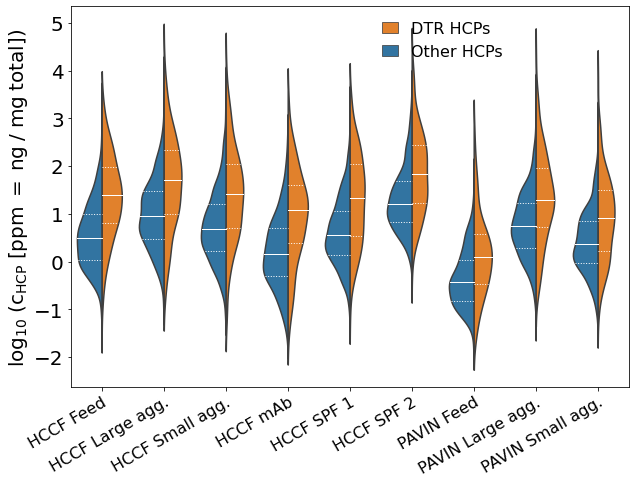

In [14]:
category = 'dtr'
label = 'DTR HCPs'

# Prepare a consolidated df_violin
for k, sample_column in enumerate(sample_columns):
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    df_plot_category[category] = label
    df_plot_other[category] = 'Other HCPs'
    df_plot_category['sample'] = nice_name_map[sample_column]
    df_plot_other['sample'] = nice_name_map[sample_column]
    if k == 0:
        df_violin = df_plot_other.copy()
    else:
        df_violin = pd.concat([df_violin, df_plot_other])
    df_violin = pd.concat([df_violin, df_plot_category])
    
df_violin.rename(columns={'c_ppm':r'$\mathsf{c_HCP}$ [ppm = ng / mg total]', 
                          'log10_c_ppm':r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$'}, inplace=True)

# Make plot
plt.gcf().set_size_inches(10, 7)
ax = sns.violinplot(data=df_violin, x='sample', y=r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$', 
                    hue=category, split=True, inner='quartile')

# Modify xtick labels
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor', fontsize=16)
hide = ax.set(xlabel=None)

# Modify legend
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=16, handlelength=1,
          loc='upper right',  bbox_transform=ax.transAxes, bbox_to_anchor=(0.8, 1.0))

# Modify quartile lines
for l in ax.lines:
    l.set_linestyle(':')
    l.set_linewidth(1)
    l.set_color('white')
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1)
    l.set_color('white')

# plt.savefig(f'./images/15_violin_{category}.png', dpi=300, bbox_inches='tight')

# Split histograms

In [11]:
def get_bin_pos(bins):
    thickness = np.diff(bins)[0]
    bin_pos = bins[:-1] + thickness/2
    return thickness, bin_pos

In [12]:
nice_names = [nice_name_map[sample_column] for sample_column in sample_columns]

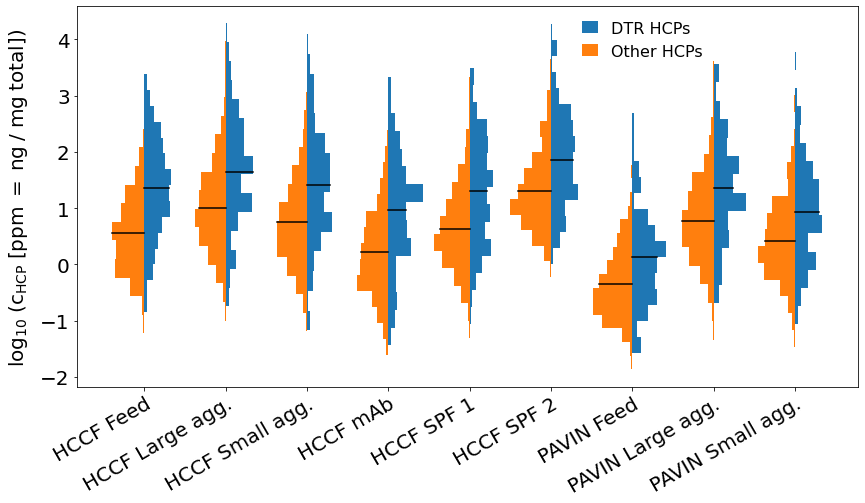

In [29]:
category = 'dtr'
label = 'DTR HCPs'

fig, ax = my_plot.instantiate_fig(x=14, y=7, ylabel=r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$')
ticks = ax.set_xticks(range(len(nice_names)), nice_names, rotation=30, ha='right', rotation_mode='anchor')

for k, sample_column in enumerate(sample_columns):
    # Retrieve data frames with just the HCPs in the category and sample column of interest along with their counterparts
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    
    # Get values in preparation for drawing bar plots
    vals_cat, bins_cat = np.histogram(df_plot_category.log10_c_ppm, density=True, bins=15)
    thickness_cat, bin_pos_cat = get_bin_pos(bins_cat)
    
    vals_other, bins_other = np.histogram(df_plot_other.log10_c_ppm, density=True, bins=15)
    thickness_other, bin_pos_other = get_bin_pos(bins_other)
    
    # Draw bar plots
    scalar = 0.7
    if k == 0:
        bar_cat = ax.barh(bin_pos_cat, scalar*vals_cat, height=thickness_cat, left=k, color='C0', label=label)
        bar_other = ax.barh(bin_pos_other, -1*scalar*vals_other, height=thickness_other, left=k, color='C1', label='Other HCPs')
    else:
        bar_cat = ax.barh(bin_pos_cat, scalar*vals_cat, height=thickness_cat, left=k, color='C0')
        bar_other = ax.barh(bin_pos_other, -1*scalar*vals_other, height=thickness_other, left=k, color='C1')
        
    # Add line for the mean
    mean_cat = df_plot_category.log10_c_ppm.mean()
    index = np.absolute(bin_pos_cat - mean_cat).argmin()
    max_x_cat = scalar * vals_cat[index]
    ax.plot([k, k+max_x_cat], [mean_cat, mean_cat], color='black')
    
    mean_other = df_plot_other.log10_c_ppm.mean()
    index = np.absolute(bin_pos_other - mean_other).argmin()
    max_x_other = scalar * vals_other[index]
    ax.plot([k-max_x_other, k], [mean_other, mean_other], color='black')
    
        
ax.legend(frameon=False, fontsize=16, handlelength=1, loc='upper right', bbox_transform=ax.transAxes, bbox_to_anchor=(0.82, 1.0))

# plt.savefig(f'./images/15_split_histogram_{category}.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/15_split_histogram_{category}.tif', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/15_split_histogram_{category}.eps', dpi=300, bbox_inches='tight')

# Split histograms + PAVIN mAb scatter points

In [9]:
nice_names = ['HCCF Feed', 'HCCF Large agg.', 'HCCF Small agg.', 'HCCF mAb', 'HCCF SPF 1', 'HCCF SPF 2', 'PAVIN Feed', 'PAVIN Large agg.', 'PAVIN Small agg.', 'PAVIN mAb']

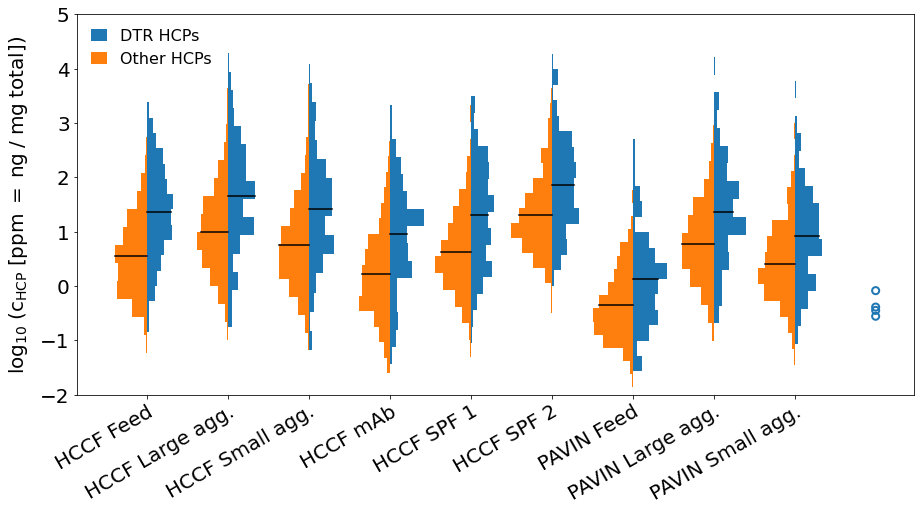

In [13]:
category = 'dtr'
label = 'DTR HCPs'

fig, ax = my_plot.instantiate_fig(x=15, y=7, ylabel=r'$\mathsf{log_{10} \; \left( c_{HCP} \; [ppm \; = \; ng \; / \; mg \; total] \right)}$')
ticks = ax.set_xticks(range(len(nice_names)), nice_names, rotation=30, ha='right', rotation_mode='anchor')

for k, sample_column in enumerate(sample_columns):
    # Retrieve data frames with just the HCPs in the category and sample column of interest along with their counterparts
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    
    # Get values in preparation for drawing bar plots
    vals_cat, bins_cat = np.histogram(df_plot_category.log10_c_ppm, density=True, bins=15)
    thickness_cat, bin_pos_cat = get_bin_pos(bins_cat)
    
    vals_other, bins_other = np.histogram(df_plot_other.log10_c_ppm, density=True, bins=15)
    thickness_other, bin_pos_other = get_bin_pos(bins_other)
    
    # Draw bar plots
    scalar = 0.7
    if k == 0:
        bar_cat = ax.barh(bin_pos_cat, scalar*vals_cat, height=thickness_cat, left=k, color='C0', label=label)
        bar_other = ax.barh(bin_pos_other, -1*scalar*vals_other, height=thickness_other, left=k, color='C1', label='Other HCPs')
    else:
        bar_cat = ax.barh(bin_pos_cat, scalar*vals_cat, height=thickness_cat, left=k, color='C0')
        bar_other = ax.barh(bin_pos_other, -1*scalar*vals_other, height=thickness_other, left=k, color='C1')
        
    # Add line for the mean
    mean_cat = df_plot_category.log10_c_ppm.mean()
    index = np.absolute(bin_pos_cat - mean_cat).argmin()
    max_x_cat = scalar * vals_cat[index]
    ax.plot([k, k+max_x_cat], [mean_cat, mean_cat], color='black')
    
    mean_other = df_plot_other.log10_c_ppm.mean()
    index = np.absolute(bin_pos_other - mean_other).argmin()
    max_x_other = scalar * vals_other[index]
    ax.plot([k-max_x_other, k], [mean_other, mean_other], color='black')
    
df_plot_other, df_plot_category = get_df_plots('pavin_mab', category)
ax.scatter(np.full(len(df_plot_category), k+1), df_plot_category.log10_c_ppm, facecolors='none', edgecolors='tab:blue', linewidth=2, s=50)
    
ax.set_ylim(-2, 5)
ax.legend(frameon=False, fontsize=16, handlelength=1, loc='upper left', bbox_transform=ax.transAxes, bbox_to_anchor=(0.0, 1.0))

# plt.savefig(f'./images/15_split_histogram_{category}_with_pavin_mab.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/15_split_histogram_{category}_with_pavin_mab.tif', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/15_split_histogram_{category}_with_pavin_mab.eps', dpi=300, bbox_inches='tight')

In [14]:
df_plot_category

,pavin_mab,c_ppm,log10_c_ppm,percentile,high_risk,dtr
name,,,,,,
C-C motif chemokine 2 [Cricetulus griseus],0.277746,0.277746,-0.556353,0.0,False,True
serine protease HTRA1 isoform X3 [Cricetulus griseus],0.355977,0.355977,-0.448578,25.0,True,True
putative phospholipase B-like 2 [Cricetulus griseus],0.409507,0.409507,-0.387739,50.0,True,True
clusterin [Cricetulus griseus],0.821371,0.821371,-0.085461,75.0,True,True


# Statistical tests

## First attempt - multiple t-tests

In [110]:
# category = 'high_risk'
# for sample_column in sample_columns:
#     df_plot_other, df_plot_category = get_df_plots(sample_column, category)
#     result = ttest_ind(df_plot_other['log10_c_ppm'], df_plot_category['log10_c_ppm'])
#     print(sample_column, '\t', df_plot_other['log10_c_ppm'].mean() < df_plot_category['log10_c_ppm'].mean(), '\t', f'{result.pvalue:.2e}')

In [111]:
# category = 'dtr'
# for sample_column in sample_columns:
#     df_plot_other, df_plot_category = get_df_plots(sample_column, category)
#     result = ttest_ind(df_plot_other['log10_c_ppm'], df_plot_category['log10_c_ppm'])
#     print(sample_column, '\t', df_plot_other['log10_c_ppm'].mean() < df_plot_category['log10_c_ppm'].mean(), '\t', f'{result.pvalue:.2e}')

## Second attempt - two-way ANOVA

In [19]:
category = 'dtr'
label = 'DTR HCPs'

# Prepare a consolidated df_violin
for k, sample_column in enumerate(sample_columns):
    df_plot_other, df_plot_category = get_df_plots(sample_column, category)
    df_plot_category[category] = label
    df_plot_other[category] = 'Other HCPs'
    df_plot_category['sample'] = nice_name_map[sample_column]
    df_plot_other['sample'] = nice_name_map[sample_column]
    if k == 0:
        df_violin = df_plot_other.copy()
    else:
        df_violin = pd.concat([df_violin, df_plot_other])
    df_violin = pd.concat([df_violin, df_plot_category])

df_violin = df_violin[['sample', 'dtr', 'log10_c_ppm']]

In [20]:
model = ols('log10_c_ppm ~ C(sample) + C(dtr) + C(sample):C(dtr)', data=df_violin).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sample),1137.624070,8.0,261.353170,0.000000e+00
C(dtr),501.680765,1.0,922.032939,2.883260e-194
C(sample):C(dtr),11.125023,8.0,2.555818,8.817542e-03
Residual,5763.137560,10592.0,NaN,NaN


In [31]:
# tukey = pairwise_tukeyhsd(endog=df_violin['log10_c_ppm'],
#                           groups=df_violin['sample'],
#                           alpha=0.05)

# print(tukey)